## Madison crime example
In this example we use the python GIS stack to look at crime in Madison, WI by neighborhood.

#### Datasets:
* City of Madison incident dataset, available from https://moto.data.socrata.com/dataset/City-of-Madison/dddr-t8pv (accessed 11/7/2016 for this example). For brevity, only the 2016 incidents are used in this example. 
* Wisconsin Neighborhood boundaries (for Madison and Milwaukee), from Zillow: http://www.zillow.com/static/shp/ZillowNeighborhoods-WI.zip (accessed 11/7/2016 for this example)  

#### Operations:
* read and write shapefiles using `GIS_utils` (macros around `fiona` and `pandas`)
* plotting shapefile contents using `matplotlib` and `descartes`
* visualizing dense point data using `datashader`
* coordinate transformations using `GIS_utils` (wrapping `pyproj` and `shapely`)
* using `shapely` to test for intersections
* using `rtree` to speed up intersections through spatial indexing
* using `pandas` for visualization and general data wrangling

In [1]:
import numpy as np
import pandas as pd
import fiona
from shapely.ops import unary_union
from shapely.geometry import Point
from descartes import PolygonPatch
from rtree import index
from matplotlib.collections import PatchCollection
from GISio import shp2df
from GISops import intersect_rtree, projectdf
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
neighborhoods = 'data/ZillowNeighborhoods-WI/ZillowNeighborhoods-WI.shp'
crimedata = 'data/MSNcrime16.csv' # 2016 incidents only

### read in the neighborhood boundaries
* `shp2df` function reads a shapefile, and returns a pandas dataframe of the attribute information, with the geometric information stored in a `geometry` column, as `shapely Point, Linstring, or Polygon` objects

In [3]:
nb = shp2df(neighborhoods)

# slice the dataframe to only include Madison neighborhoods
msn = nb[nb.CITY == 'Madison'].copy()

# use `shapely` to join the neighborhood polyons into one MultiPolygon, 
# so that we can get a single bounding box for all of them
msn_extents = unary_union(msn.geometry)


reading data/ZillowNeighborhoods-WI/ZillowNeighborhoods-WI.shp...
--> building dataframe... (may take a while for large shapefiles)


In [4]:
x1, y1, x2, y2 = msn_extents.bounds
msn_extents.bounds

(-89.5638730407713, 43.0013466486199, -89.2551904508282, 43.1612654379281)

### make a quick plot of the neighborhoods using `descartes` and `matplotlib.pyplot`
* `PolygonPatch` converts the `shapley Polygon` objects to `matplotlib patches`

(-89.5638730407713, -89.2551904508282)

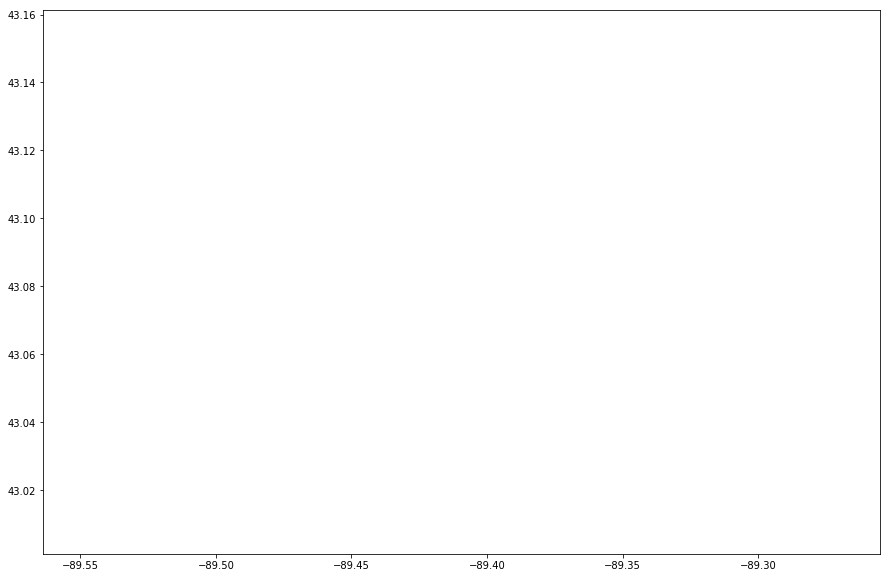

In [5]:
fig, ax = plt.subplots(figsize=(15, 10))
collection = PatchCollection([PolygonPatch(p) for p in msn.geometry], facecolor='w')
ax.add_collection(collection)
ax.set_ylim(y1, y2)
ax.set_xlim(x1, x2)

### Read indicident data into `pandas DataFrame`

In [6]:
df = pd.read_csv(crimedata)
df.index = pd.to_datetime(df.incident_datetime)
df.head()

/Users/aleaf/anaconda/envs/gis/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,incident_id,case_number,incident_datetime,incident_type_primary,incident_description,clearance_type,address_1,address_2,city,state,...,created_at,updated_at,location,hour_of_day,day_of_week,parent_incident_type,City of Madison Sector Shapes - 54pa-kaun,City of Madison Aldermanic District Shapes - w9zi-qe9k,City of Madison Police District Shapes - ygny-ea98,geometry
incident_datetime,,,,,,,,,,,,,,,,,,,,,
2016-06-11 06:05:02,761997524,-7496364,06/11/2016 06:05:02 AM,Information,Information,NaN,USH 12 WB & S PARK ST,NaN,"MADISON, CITY OF",WI,...,06/12/2016 08:49:34 AM,06/25/2016 11:02:34 AM,POINT (-88.7878678 43.7844397),6,Saturday,Community Policing,NaN,NaN,NaN,POINT (356140.3129989149 4849484.828885946)
2016-06-11 06:33:15,761998669,-7496368,06/11/2016 06:33:15 AM,Check Person,Check Person,NaN,200 Block STATE ST,NaN,MADISON,WI,...,06/12/2016 08:52:00 AM,06/25/2016 11:08:46 AM,POINT (-89.3882098 43.0749211),6,Saturday,Community Policing,190315.0,190376.0,190262.0,POINT (305573.7594097918 4771902.909003322)
2016-06-11 06:35:11,761997698,-7496369,06/11/2016 06:35:11 AM,Stolen Auto,Stolen Auto,NaN,6700 Block SCHROEDER RD,NaN,MADISON,WI,...,06/12/2016 08:50:13 AM,06/25/2016 11:07:08 AM,POINT (-89.499497 43.044049),6,Saturday,Theft of Vehicle,190369.0,190373.0,190266.0,POINT (296411.201908139 4768738.445475894)
2016-06-11 06:55:47,761998662,-7496373,06/11/2016 06:55:47 AM,Alarm,Alarm,NaN,2200 Block E WASHINGTON AVE,NaN,MADISON,WI,...,06/12/2016 08:52:00 AM,06/25/2016 11:10:52 AM,POINT (-89.3548317 43.0976068),6,Saturday,Alarm,190295.0,190384.0,190264.0,POINT (308361.9774307359 4774345.43972354)
2016-06-11 07:04:22,761997892,-7496376,06/11/2016 07:04:22 AM,Stolen Auto,Stolen Auto,NaN,1 Block GROVE CIR,NaN,MADISON,WI,...,06/12/2016 08:50:26 AM,06/25/2016 11:07:25 AM,POINT (-89.507437 43.010549),7,Saturday,Theft of Vehicle,190367.0,190379.0,190266.0,POINT (295653.2771457943 4765037.360292315)


### Count number of incidents by date, and plot

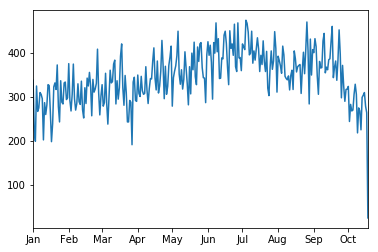

In [7]:
import matplotlib.dates as dates
ax = df.groupby(df.index.date).count().incident_id.plot()
ax.xaxis.set_major_formatter(dates.DateFormatter('%b'))


In [8]:
df.columns

Index(['incident_id', 'case_number', 'incident_datetime',
       'incident_type_primary', 'incident_description', 'clearance_type',
       'address_1', 'address_2', 'city', 'state', 'zip', 'country', 'latitude',
       'longitude', 'created_at', 'updated_at', 'location', 'hour_of_day',
       'day_of_week', 'parent_incident_type',
       'City of Madison Sector Shapes - 54pa-kaun',
       'City of Madison Aldermanic District Shapes - w9zi-qe9k',
       'City of Madison Police District Shapes - ygny-ea98', 'geometry'],
      dtype='object')

### list the all of the incident types in that dataset

In [9]:
df.incident_type_primary.unique()

array(['Information', 'Check Person', 'Stolen Auto', 'Alarm',
       'Alarm Broadcast and File', 'Pvt Prop Parking Complaint',
       'EMS Assist', 'Accident Property Damage', 'Suspicious Vehicle',
       'Check Property', 'Domestic Disturbance', 'Noise Complaint',
       'Traffic Stop', 'Preserve the Peace', 'Disturbance',
       'Theft from Auto', 'Traffic Complaint/Investigation',
       'Damage to Property', 'Overdose', 'Accident Hit and Run',
       'Accident Private Property', 'Foot Patrol', 'Neighbor Trouble',
       'Towed Vehicle/Abandonment', 'Suspicious Person', 'RetailTheft',
       'Missing Juvenile', 'Drug Investigation', 'Accident w/Injuries',
       'Trespass', 'Fraud', 'OMVWI Arrest/Intoxicated Driver',
       'Civil Dispute', 'Intoxicated Person', 'Fight Call',
       'Accident Unknown Injury', 'Battery', 'Theft', 'Traffic Incident',
       'Stolen Bicycle', 'Person with a Gun', 'Robbery - Armed',
       'Towed Vehicle', 'Non-Residential Burglary',
       'Rec/Stolen/

### Add the incidents to the map with neighborhoods
* overplotting of points in dense areas prevents us from seeing how much crime they actually have

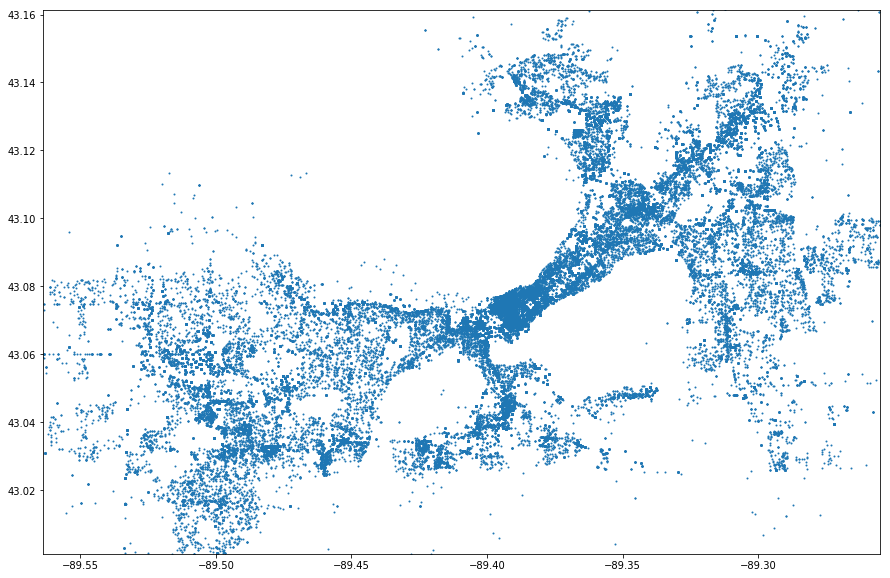

In [10]:
fig, ax = plt.subplots(figsize=(15, 10))
collection = PatchCollection([PolygonPatch(p) for p in msn.geometry], facecolor='w')
ax.add_collection(collection)
ax.set_ylim(y1, y2)
ax.set_xlim(x1, x2)
ax.scatter(df.longitude, df.latitude, s=1)

## Plot crime density by pixel using `datashader`
more info on `datashader` here: https://github.com/bokeh/datashader

In [11]:
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import Hot, colormap_select as cm

#### html colors that will represent the crime bins

In [12]:
cm(Hot,0.2)

['darkred',
 'red',
 'orangered',
 'darkorange',
 'orange',
 'gold',
 'yellow',
 'white']

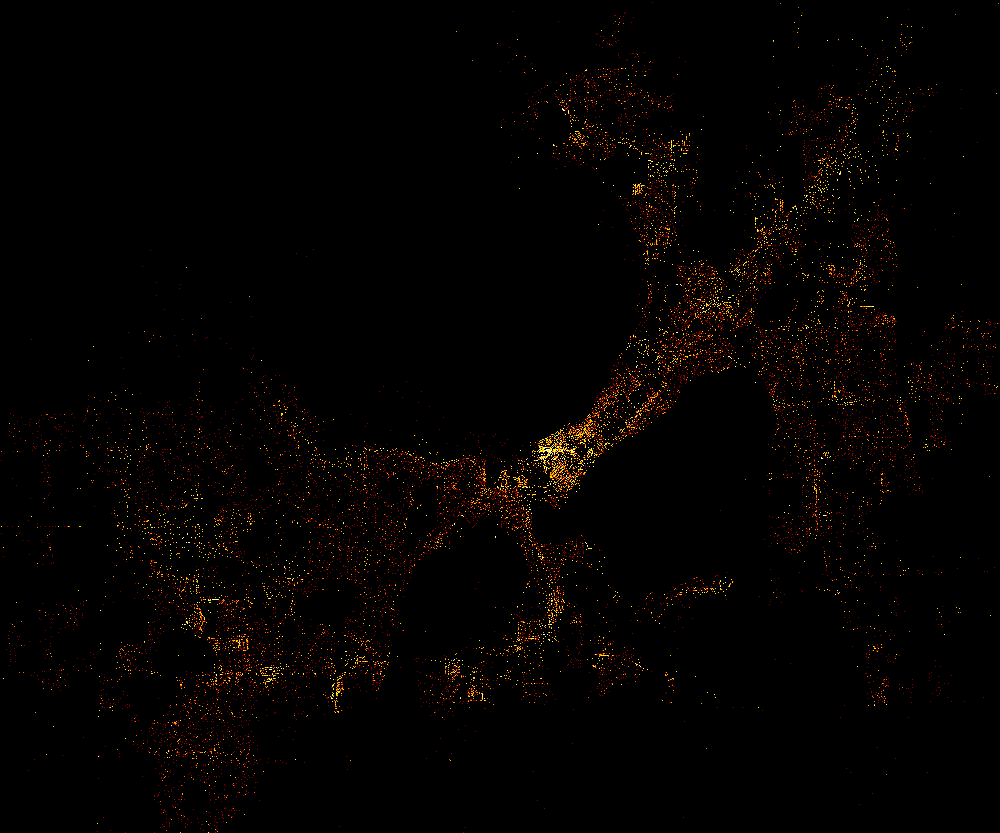

In [13]:
#pixel dimensions of plot
plot_width  = int(1e3)
plot_height = int(plot_width//1.2)

# make plot
cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height, x_range=(x1, x2), y_range=(y1, y2))
agg = cvs.points(df, 'longitude', 'latitude')
img = tf.shade(agg, cmap=cm(Hot,0.2), how='eq_hist')
tf.set_background(img, 'black')

### Convert both datasets to UTM for computing distances
the `projectdf` function in `GIS_utils` takes a dataframe that has a "geometry" column of `shapely` geometry objects, and reprojects those objects from one coordinate system to another
* source and destination coordinate systems are defined with proj4 strings  
https://trac.osgeo.org/proj/wiki/GenParms  
http://spatialreference.org/
* `projectdf` returns a list of geometry objects in the destination coordinate system

In [14]:
# make a list of neighborhood polygons reprojected to utm coordinates
msn_geoms_utm = projectdf(msn, 
                            '+init=epsg:4269', # proj4 string for original coordinate system (NAD 83 degrees)
                            '+init=epsg:26916' # proj4 for destination coordinate system (UTM 83 zone 16)
                           )
list(msn_geoms_utm[0].exterior.coords)[:10]

[(297119.39774868556, 4772987.20664378),
 (297255.57144277357, 4772982.448267026),
 (297284.9005368294, 4772985.11061105),
 (297324.7977846271, 4772987.953219418),
 (297366.5768027826, 4773017.605552135),
 (297390.340707515, 4773046.292408941),
 (297401.8906360038, 4773072.534591215),
 (297422.7476688732, 4773080.316316182),
 (297423.5868896919, 4773092.569121835),
 (297423.6248469213, 4773093.122877988)]

#### Get ride of invalid points first to minimize issues in the spatial join
* invalid points can cause ```rtree``` to crash

In [15]:
# drop indicents without lat/lon values
df.dropna(axis=0, subset=['longitude', 'latitude'], inplace=True)

# make shapley point objects out of the lat, lon values
df['geometry'] = [Point(*xy) for xy in zip(df.longitude.values, df.latitude.values)]

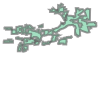

In [16]:
# drop any points that aren't within the city (using the polygon we defined earlier)
# use the bounds because the union of the neighborhood polygons is too complex
# (meaning it will take shapely a while to determine intersections)
msn_extents

In [17]:
msn_extents.bounds

(-89.5638730407713, 43.0013466486199, -89.2551904508282, 43.1612654379281)

In [18]:
from shapely.geometry import box # makes a polygon out of bounding coordinates
bounds = box(*msn_extents.bounds)
within = [g.within(bounds) for g in df.geometry] # test whether each incident is within the bounding box
print(within[0:100])

[False, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False]


In [ ]:
df = df[within].copy() # make a copy so that we are no longer working with the old DataFrame

In [ ]:
# now make a list of incident locations in utm
crime_points_utm = projectdf(df, 
                            '+init=epsg:4269', # proj4 string for original coordinate system (NAD 83 degrees)
                            '+init=epsg:26916' # proj4 for destination coordinate system (UTM 83 zone 16)
                           )

In [ ]:
len(df),len(msn)

### Aggregate the number of incidents by neighborhood
* this requires each point to be tested for each neighborhood (11.7 million operations if we have 94,513 incidents and 124 neighborhoods)
* the `rtree` package speeds up this process via spatial indexing  
https://en.wikipedia.org/wiki/R-tree
* use the ```intersect_rtree``` macro for convenience
* `intersect_rtree` takes two lists of shapely geometry objects, and
    * reduces objects in the first list to bounding boxes, and builds an rtree spatial index of them
    * for each object in list 2, uses rtree to find the bounding boxes in list 1 that intersect the bounding boxe of the object
        * from the initial list of bounding box intersections, uses shapely to test the actual geometric features for intersection with each other

In [ ]:
inds = intersect_rtree(crime_points_utm, msn_geoms_utm)

#### ```intersect_rtree``` returns a lists of lists  
* (length equal to the number of neighborhood polygons), 
* each inner list containing the indicies of points within that neighborhood

In [ ]:
print(inds[0])

### count the number of incidents in each neighborhood  
* assign this to a new column in the neighborhoods dataframe

In [ ]:
msn['n_incidents'] = [len(i) for i in inds]
msn.n_incidents.hist(bins=100)

### plot number of incidents by neighborhood
* crime in the downtown area is an order of magnitude higher than anywhere else
* set the color scale accordingly so it doesn't wash out variability elsewhere

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))

# make a patch collection of the neighborhood polygons
collection = PatchCollection([PolygonPatch(p) for p in msn.geometry], facecolor='w')

# set an array of color values for the neighborhood patches
collection.set_array(msn.n_incidents.values)

# set the color limit based on the histogram above
collection.set_clim(0, 4000)

# add the collection to the plot
ax.add_collection(collection)
ax.set_ylim(y1, y2)
ax.set_xlim(x1, x2)
fig.colorbar(collection)

## Finish the spatial join
* add the neighborhoods to the crime dataframe to allow for additional analyses

In [ ]:
msn.head()

In [ ]:
# make an empty array of strings the same length as the dataframe
# the dtype has to be an object or large enough string to accommodate the long neighborhood names
neighborhoods = np.array([''] * len(df), dtype=np.object)

# now iterate through the neighborhoods dataframe and assign the neighborhood name to the indices we got from rtree
for i, n in enumerate(msn.NAME):
    neighborhoods[inds[i]] = n
neighborhoods

In [ ]:
# assign this to a new column in the incidents dataframe
df['neighborhood'] = neighborhoods
df.head()